In [2]:
import os
os.chdir('/data/l989o/deployed/a')
import sys
if '/data/l989o/a' in sys.path:
    sys.path.remove('/data/l989o/a')    

In [3]:
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import pickle
import pandas as pd
from data import file_path
from tqdm.notebook import tqdm

True
<KeysViewHDF5 ['count', 'maximum', 'mean', 'sum', 'variance']>


In [4]:
from data import TransformedMeanDataset
ds0 = TransformedMeanDataset('train')
n = 0
for x in ds0:
    n += len(x)
print(n)

ds1 = TransformedMeanDataset('validation')
v = 0
for x in ds1:
    v += len(x)
print(v)
print(n + v)

449434
220218
669652


In [134]:
class Quantities:
    def __init__(self):
        self.phenographs = dict()
        self.adata = dict()
        self.num_phenograph_classes = dict()
        self.all_fractions = dict()
        self.omes = dict()

q = Quantities()
        
for method in ['raw', 'transformed', 'vae_mu']:
    f = file_path(f'umap_{method}.adata')
    a = ad.read(f)
    print(a)
    a = a[:n].copy()
    print(a)

    index_info_omes, index_info_begins, index_info_ends = pickle.load(open(file_path('merged_cells_info.pickle'), 'rb'))
    print(index_info_ends[-1])

    l = []
    b = file_path(f'phenograph_{method}.hdf5')
    with h5py.File(b, 'r') as f:
        for i, o in enumerate(index_info_omes):
            phenograph = f[o]['phenograph'][...].reshape((-1, 1))
            assert len(phenograph) == index_info_ends[i] - index_info_begins[i]
            l.append(phenograph)
    phenographs = np.concatenate(l, axis=0)
    phenographs.shape
    q.phenographs[method] = phenographs

    s = pd.Series(phenographs.flatten(), dtype='category')
    print(s)
    s.index = a.obs.index

    a.obs['phenograph'] = s
    display(a.obs)
    q.adata[method] = a

    # sc.pl.umap(a, color='phenograph')

    num_phenograph_classes = np.max(phenographs) + 1
    q.num_phenograph_classes[method] = num_phenograph_classes
    print(num_phenograph_classes)
    a = len(set(phenographs.flatten().tolist()))
    assert num_phenograph_classes == a, a

    phenograph_fractions = dict()
    with h5py.File(b, 'r') as f:
        q.omes[method] = list(f.keys())
        for i, o in tqdm(enumerate(index_info_omes), desc='computing fractions'):
            phenograph = f[o]['phenograph'][...].reshape((-1, 1))
            assert len(phenograph) == index_info_ends[i] - index_info_begins[i]
            fractions = np.zeros((num_phenograph_classes))
            for p in phenograph.flatten():
                fractions[p] += 1
            fractions /= np.sum(fractions)
            phenograph_fractions[o] = fractions.reshape((1, -1))
    print(len(phenograph_fractions))
    all_fractions = np.concatenate(list(phenograph_fractions.values()), axis=0)
    print(all_fractions.shape)
    q.all_fractions[method] = all_fractions

AnnData object with n_obs × n_vars = 669652 × 39
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 449434 × 39
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
449434
0          6
1          3
2          3
3          1
4         22
          ..
449429    19
449430    12
449431     3
449432     2
449433    19
Length: 449434, dtype: category
Categories (58, int64): [0, 1, 2, 3, ..., 54, 55, 56, 57]


,phenograph
0,6
1,3
2,3
3,1
4,22
...,...
449429,19
449430,12
449431,3
449432,2


58



226
(226, 58)
AnnData object with n_obs × n_vars = 669652 × 39
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 449434 × 39
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
449434
0         0
1         0
2         0
3         0
4         0
         ..
449429    1
449430    8
449431    3
449432    3
449433    1
Length: 449434, dtype: category
Categories (78, int64): [0, 1, 2, 3, ..., 74, 75, 76, 77]


,phenograph
0,0
1,0
2,0
3,0
4,0
...,...
449429,1
449430,8
449431,3
449432,3


78



226
(226, 78)
AnnData object with n_obs × n_vars = 669652 × 5
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 449434 × 5
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
449434
0         16
1         16
2         19
3         17
4          6
          ..
449429    12
449430     6
449431    22
449432    20
449433    11
Length: 449434, dtype: category
Categories (30, int64): [0, 1, 2, 3, ..., 26, 27, 28, 29]


,phenograph
0,16
1,16
2,19
3,17
4,6
...,...
449429,12
449430,6
449431,22
449432,20


30



226
(226, 30)


In [138]:
q.fractions_u = dict()
q.dbscan_labels = dict()

for method in ['raw', 'transformed', 'vae_mu']:
    print('-' * 100)
    print('method =', method)
    from umap import UMAP
    reducer = UMAP(2, verbose=True)
    u = reducer.fit_transform(q.all_fractions[method])
    q.fractions_u[method] = u

    from sklearn.cluster import DBSCAN
    clustering = DBSCAN(eps=1, min_samples=2).fit(u)
    print(clustering.labels_)
    print(clustering)
    q.dbscan_labels[method] = clustering.labels_

    print(type(clustering.labels_))
    print(clustering.labels_.shape)

----------------------------------------------------------------------------------------------------
method = raw
UMAP(n_neighbors=2, verbose=True)
Construct fuzzy simplicial set
Mon Jan 18 18:57:29 2021 Finding Nearest Neighbors
Mon Jan 18 18:57:29 2021 Finished Nearest Neighbor Search
Mon Jan 18 18:57:29 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jan 18 18:57:30 2021 Finished embedding
[ 0  1  2  3  4  4  5  6  7  8  4  9  4 10 11 12 13  1 14  4 15 10 16 17
  8 16 18 19  4  9 13 20 21 20 22 21  4 17 17 23 24 15 14 16 11 18 25  9
 11  4  4 24  3 15 26 16 27  9 28 29 30  1 28 30 26 23 10 18 28 18  0 18
  9 18 23 22 10 26 16  8  6  7 31 12 32  3 32  6 21 33 12 34 31  7 30 12
 33  6 32 17 14 31 31 35

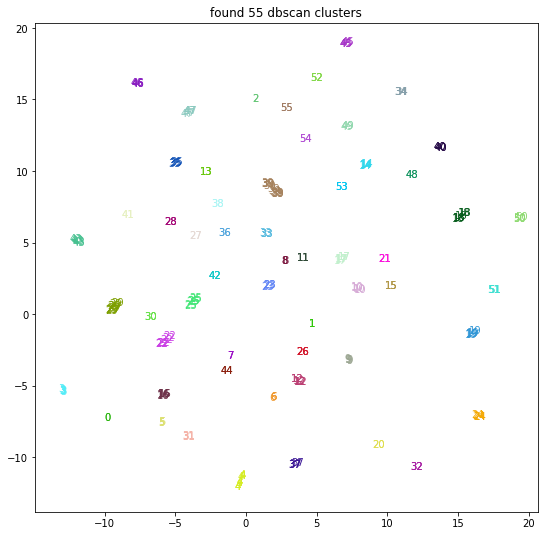

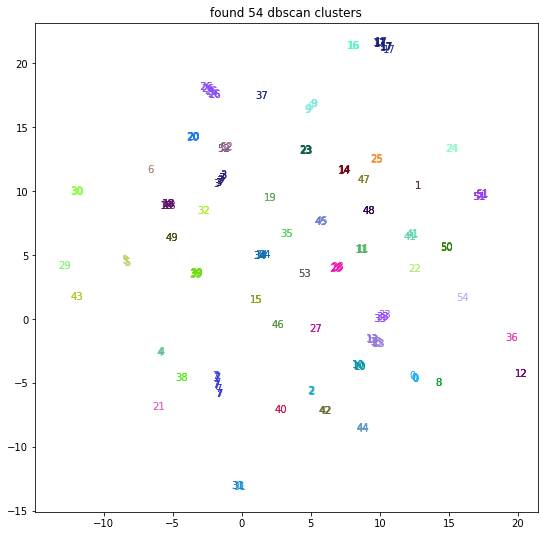

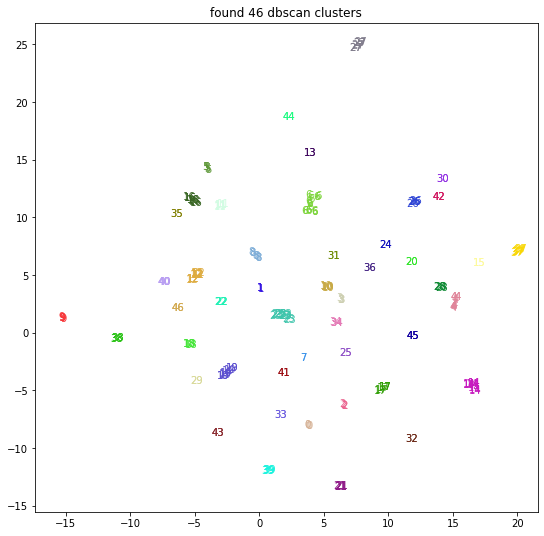

In [46]:
for method in ['raw', 'transformed', 'vae_mu']:
    labels = q.dbscan_labels[method]
    u = q.fractions_u[method]
    plt.figure(figsize=(9, 9))
    colors = np.random.random((1000, 3))[labels]
    plt.scatter(u[:, 0], u[:, 1], c=colors, alpha=0)
    ax = plt.gca()
    texts = list(map(str, labels))    
    for i in range(len(u)):
        ax.annotate(texts[i], (u[i, 0], u[i, 1]), color=colors[i])
    # plt.text(u[:, 0], u[:, 1], texts, color=colors)
    plt.title(f'found {max(labels)} dbscan clusters')
    plt.show()

12
10
9
7


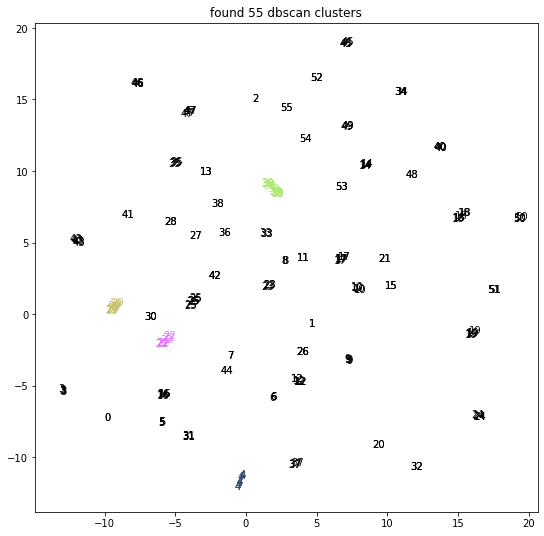

6
3
2
2


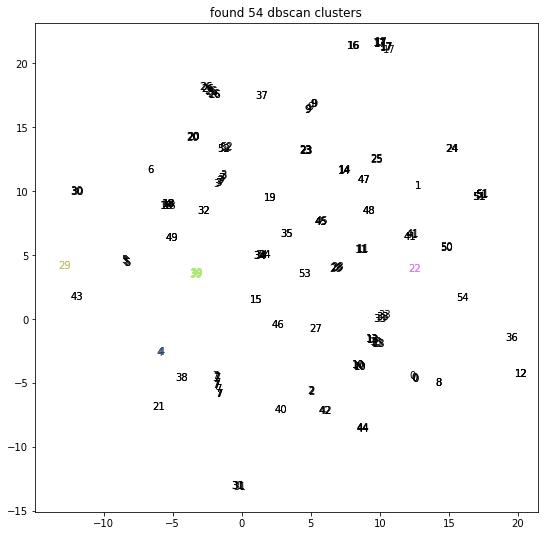

4
12
2
4


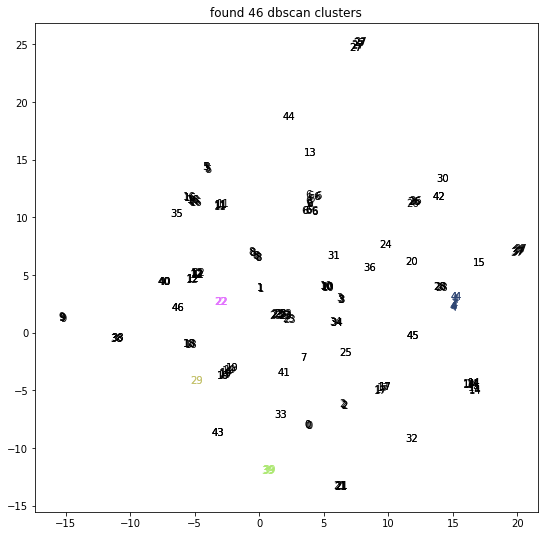

In [120]:
random_colors = np.random.rand(4, 3)

for method in ['raw', 'transformed', 'vae_mu']:
    labels = q.dbscan_labels[method]
    u = q.fractions_u[method]
    plt.figure(figsize=(9, 9))
    colors = np.tile([0., 0., 0.], (len(labels), 1))
    hot_indices = [39, 4, 29, 22]
    for color, index in zip(random_colors, hot_indices):
        matches = np.where(labels == index)
        print(len(matches[0]))
        colors[matches, :] = color
    plt.scatter(u[:, 0], u[:, 1], c=colors, alpha=0)
    ax = plt.gca()
    texts = list(map(str, labels))    
    for i in range(len(u)):
        ax.annotate(texts[i], (u[i, 0], u[i, 1]), color=colors[i])
    # plt.text(u[:, 0], u[:, 1], texts, color=colors)
    plt.title(f'found {max(labels)} dbscan clusters')
    plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55]), array([ 2,  3,  2,  6, 10,  4,  4,  3,  3,  5,  4,  3,  6,  3,  4,  3,  5,
        6,  6,  5,  2,  3,  7,  4,  5,  7,  4,  2,  3,  9,  3,  4,  3,  3,
        4,  4,  2,  4,  2, 12,  4,  2,  3,  5,  2,  4,  4,  5,  2,  3,  4,
        4,  3,  3,  2,  2]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54]), array([ 5,  2,  3,  9,  3,  5,  2, 15,  3,  8,  5,  4,  4,  8,  4,  3,  3,
       10,  7,  3,  4,  2,  2,  5,  3,  3,  9,  2,  4,  2,  3,  4,  3,  5,
        7,  3,  2,  2,  2,  6,  2,  4,  3,  2,  4,  4,  2,  3,  3,  3,  3,
        6,  4, 

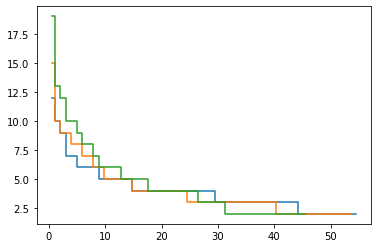

In [39]:
plt.figure()
methods = ['raw', 'transformed', 'vae_mu']
for method in methods:
    a = q.dbscan_labels[method]
    print(np.unique(a, return_counts=True))
    h, bin_edges = np.histogram(a, max(a) + 1)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    h = [-a for a in sorted(-h)]
    plt.step(bin_centers, h, where='mid')
#     s = sorted(bins)
#     plt.bar(mids, s)
plt.show()

----------------------------------------------------------------------------------------------------
score: 0.10572371543764972


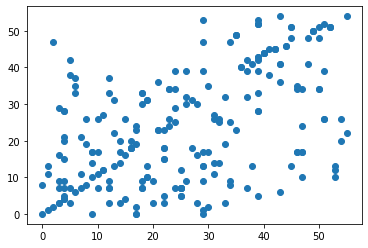

[(0, 39), (0, 39), (0, 39), (0, 39), (0, 39), (0, 39), (0, 39), (0, 39), (0, 39), (0, 39), (0, 39), (0, 39), (1, 4), (1, 4), (1, 4), (1, 4), (1, 4), (1, 4), (1, 4), (1, 4), (1, 4), (1, 4), (2, 29), (2, 29), (2, 29), (2, 29), (2, 29), (2, 29), (2, 29), (2, 29), (2, 29), (3, 22), (3, 22), (3, 22), (3, 22), (3, 22), (3, 22), (3, 22), (4, 25), (4, 25), (4, 25), (4, 25), (4, 25), (4, 25), (4, 25), (5, 3), (5, 3), (5, 3), (5, 3), (5, 3), (5, 3), (6, 12), (6, 12), (6, 12), (6, 12), (6, 12), (6, 12), (7, 17), (7, 17), (7, 17), (7, 17), (7, 17), (7, 17), (8, 18), (8, 18), (8, 18), (8, 18), (8, 18), (8, 18), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (10, 16), (10, 16), (10, 16), (10, 16), (10, 16), (11, 19), (11, 19), (11, 19), (11, 19), (11, 19), (12, 24), (12, 24), (12, 24), (12, 24), (12, 24), (13, 43), (13, 43), (13, 43), (13, 43), (13, 43), (14, 47), (14, 47), (14, 47), (14, 47), (14, 47), (15, 5), (15, 5), (15, 5), (15, 5), (16, 6), (16, 6), (16, 6), (16, 6), (17, 10), (17, 10), (17, 10), (1

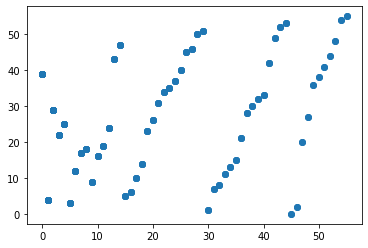

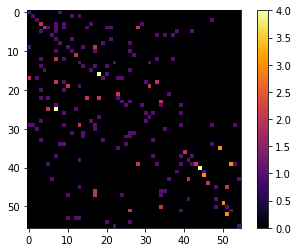

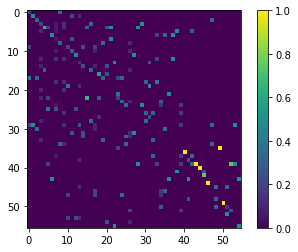

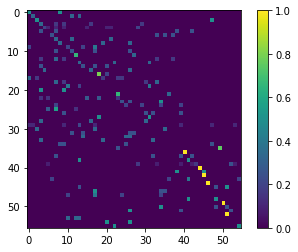

----------------------------------------------------------------------------------------------------
score: 0.17162192099917203


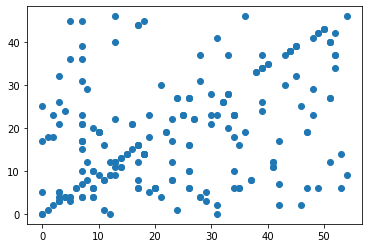

[(0, 7), (0, 7), (0, 7), (0, 7), (0, 7), (0, 7), (0, 7), (0, 7), (0, 7), (0, 7), (0, 7), (0, 7), (0, 7), (0, 7), (0, 7), (1, 17), (1, 17), (1, 17), (1, 17), (1, 17), (1, 17), (1, 17), (1, 17), (1, 17), (1, 17), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (3, 26), (3, 26), (3, 26), (3, 26), (3, 26), (3, 26), (3, 26), (3, 26), (3, 26), (4, 9), (4, 9), (4, 9), (4, 9), (4, 9), (4, 9), (4, 9), (4, 9), (5, 13), (5, 13), (5, 13), (5, 13), (5, 13), (5, 13), (5, 13), (5, 13), (6, 18), (6, 18), (6, 18), (6, 18), (6, 18), (6, 18), (6, 18), (7, 34), (7, 34), (7, 34), (7, 34), (7, 34), (7, 34), (7, 34), (8, 39), (8, 39), (8, 39), (8, 39), (8, 39), (8, 39), (9, 51), (9, 51), (9, 51), (9, 51), (9, 51), (9, 51), (10, 0), (10, 0), (10, 0), (10, 0), (10, 0), (11, 5), (11, 5), (11, 5), (11, 5), (11, 5), (12, 10), (12, 10), (12, 10), (12, 10), (12, 10), (13, 23), (13, 23), (13, 23), (13, 23), (13, 23), (14, 33), (14, 33), (14, 33), (14, 33), (14, 33), (15, 11), (15, 11), (15, 1

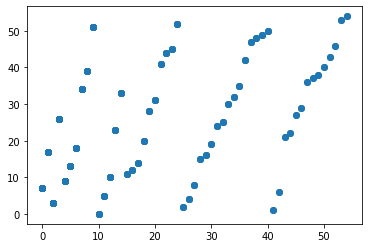

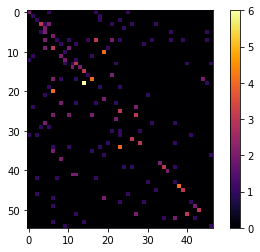

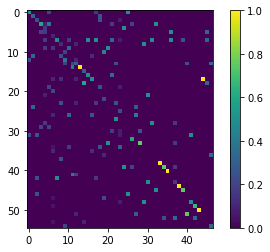

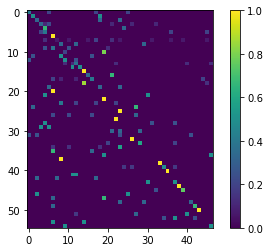

----------------------------------------------------------------------------------------------------
score: 0.0950633901220943


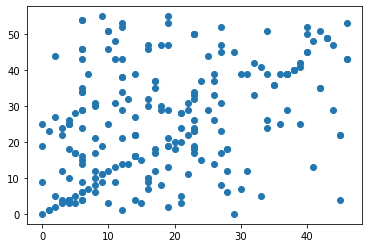

[(0, 6), (0, 6), (0, 6), (0, 6), (0, 6), (0, 6), (0, 6), (0, 6), (0, 6), (0, 6), (0, 6), (0, 6), (0, 6), (0, 6), (0, 6), (0, 6), (0, 6), (0, 6), (0, 6), (1, 23), (1, 23), (1, 23), (1, 23), (1, 23), (1, 23), (1, 23), (1, 23), (1, 23), (1, 23), (1, 23), (1, 23), (1, 23), (2, 4), (2, 4), (2, 4), (2, 4), (2, 4), (2, 4), (2, 4), (2, 4), (2, 4), (2, 4), (2, 4), (2, 4), (3, 12), (3, 12), (3, 12), (3, 12), (3, 12), (3, 12), (3, 12), (3, 12), (3, 12), (3, 12), (4, 14), (4, 14), (4, 14), (4, 14), (4, 14), (4, 14), (4, 14), (4, 14), (4, 14), (4, 14), (5, 19), (5, 19), (5, 19), (5, 19), (5, 19), (5, 19), (5, 19), (5, 19), (5, 19), (6, 8), (6, 8), (6, 8), (6, 8), (6, 8), (6, 8), (6, 8), (6, 8), (7, 16), (7, 16), (7, 16), (7, 16), (7, 16), (7, 16), (7, 16), (7, 16), (8, 27), (8, 27), (8, 27), (8, 27), (8, 27), (8, 27), (8, 27), (9, 10), (9, 10), (9, 10), (9, 10), (9, 10), (9, 10), (10, 17), (10, 17), (10, 17), (10, 17), (10, 17), (10, 17), (11, 21), (11, 21), (11, 21), (11, 21), (11, 21), (11, 21), 

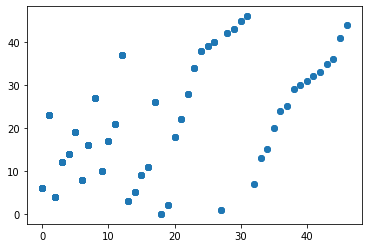

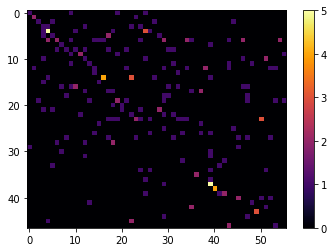

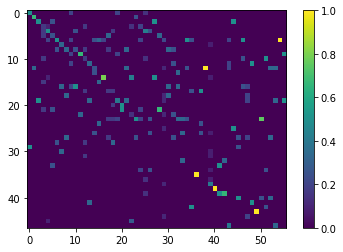

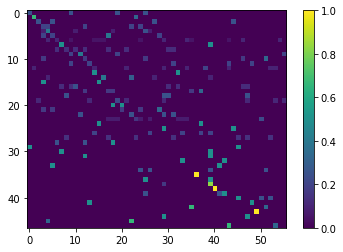

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [122]:
from sklearn.metrics import adjusted_rand_score
from operator import itemgetter

def get_m(method0, method1):
    print('-' * 100)
    n0 = max(q.dbscan_labels[method0]) + 1
    n1 = max(q.dbscan_labels[method1]) + 1    
    labels0 = q.dbscan_labels[method0]
    labels1 = q.dbscan_labels[method1]
    print('score:', adjusted_rand_score(labels0, labels1))
    plt.figure()
    plt.scatter(q.dbscan_labels[method0], q.dbscan_labels[method1])
    plt.show()
    
    counts0 = dict(zip(*np.unique(labels0, return_counts=True)))
    indices, sorted_labels0 = zip(*sorted(enumerate(labels0), key=lambda x: (-counts0[x[1]], x[1])))
#     print(sorted_labels0)
    
    seen = set()
    no_duplicates = [x for x in sorted_labels0 if not (x in seen or seen.add(x))]
    l = list(range(max(seen) + 1))
    assert len(l) == len(no_duplicates)
    map = zip(l, no_duplicates)
    relabeled0 = [no_duplicates.index(i) for i in sorted_labels0]
#     print(relabeled0)
    s = adjusted_rand_score(sorted_labels0, relabeled0)
    assert np.isclose(s, 1.), s
    
    sorted_labels1 = [labels1[i] for i in indices]
#     print(sorted_labels1)
    
    seen = set()
    no_duplicates = [x for x in sorted_labels1 if not (x in seen or seen.add(x))]
    l = list(range(max(seen) + 1))
    assert len(l) == len(no_duplicates)
    map = zip(l, no_duplicates)
    relabeled1 = [no_duplicates.index(i) for i in sorted_labels1]
#     print(relabeled0)
    s = adjusted_rand_score(sorted_labels1, relabeled1)
    assert np.isclose(s, 1.), s
#     counts1 = dict(zip(*np.unique(labels1, return_counts=True)))
#     sorted_labels1  = sorted(labels1, key=lambda x: (-counts1[x], x))
    
    plt.figure()
    print(list(zip(relabeled0, sorted_labels0)))
    print(list(zip(relabeled1, sorted_labels1)))
    plt.scatter(relabeled0, sorted_labels0)
    plt.show()
    
    m = np.zeros((n0, n1))
    for a, b in zip(labels0, labels1):
#     for a, b in zip(relabeled0, relabeled1):
        m[a, b] += 1
        
    m_rows = m.copy()
    m_cols = m.copy()
    m_rows = m_rows / np.sum(m_rows, axis=0, keepdims=True)
    m_cols = m_cols / np.sum(m_cols, axis=1, keepdims=True)
    
    plt.figure()
    plt.imshow(m, cmap='inferno')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(m_rows)
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(m_cols)
    plt.colorbar()
    plt.show()
    return m

get_m('raw', 'transformed')
get_m('transformed', 'vae_mu')
get_m('vae_mu', 'raw')

In [163]:
from metadata import get_metadata
df = get_metadata()
display(df)
print(df['Subtype'].value_counts())

discarding 153 omes from the Basel cohort, remaining: 223
discarding 153 omes from the Zurich cohort, remaning: 229
clearing metadata
flattening PTNM_T labels
flattening PTNM_N labels
metadata cleaned


,FileName_FullStack,merged_pid,diseasestatus,PrimarySite,Subtype,clinical_type,Height_FullStack,Width_FullStack,area,sum_area_cells,Count_Cells,PTNM_T,PTNM_N,PTNM_M,DFSmonth,OSmonth,images_per_patient,images_per_patient_filtered,cohort
2,BaselTMA_SP41_15.475kx12.665ky_10000x8500_5_20...,166,tumor,breast,PR-ER-,TripleNeg,723,749,541527,356411,3068,T2,pN0,M0,35.0,37.0,1,1,basel
3,BaselTMA_SP41_25.475kx12.665ky_8000x8500_3_201...,238,tumor,breast,PR+ER+,HR+HER2-,840,712,598080,286198,3173,T1,pN2,M0,140.0,233.0,2,2,basel
4,BaselTMA_SP41_25.475kx12.665ky_8000x8500_3_201...,238,non-tumor,breast,PR+ER+,HR+HER2-,765,689,527085,193119,2121,T1,pN2,M0,140.0,233.0,2,2,basel
6,BaselTMA_SP41_25.475kx12.665ky_8000x8500_3_201...,68,tumor,breast,PR+ER+,HR+HER2-,689,688,474032,218846,2262,T1,pN2,M0,169.0,169.0,2,1,basel
7,BaselTMA_SP41_15.475kx12.665ky_10000x8500_5_20...,72,tumor,breast,PR-ER+,HR+HER2-,716,737,527692,289717,2740,T1,pN0,pM1,186.0,186.0,2,1,basel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,ZTMA208_slide_13.25kx14.95ky_7000x7000_8_20171...,308,tumor,breast,PR+ER+,NaN,492,514,252888,243839,3674,TX,pNX,pM1,NaN,NaN,6,4,zurich
354,ZTMA208_slide_28.23kx22.4ky_7000x7000_5_201711...,301,tumor,breast,PR+ER+,NaN,503,475,238925,98597,1256,T3,pN1,pM1,NaN,NaN,6,4,zurich
355,ZTMA208_slide_28.23kx22.4ky_7000x7000_5_201711...,301,tumor,breast,PR+ER+,NaN,450,541,243450,102638,1227,T3,pN1,pM1,NaN,NaN,6,4,zurich
356,ZTMA208_slide_28.23kx22.4ky_7000x7000_5_201711...,301,tumor,breast,PR+ER+,NaN,464,519,240816,123359,1580,T3,pN1,pM1,NaN,NaN,6,4,zurich


PR+ER+    304
PR-ER-     68
PR-ER+     66
PR+ER-      9
Name: Subtype, dtype: int64


In [170]:
cohort_info = df.loc[df['FileName_FullStack'].isin(q.omes['raw']), 'cohort'].apply(lambda x: 0 if x == 'basel' else 1).to_numpy()
def f(x):
    assert type(x) == float and np.isnan(x) or x in ['PR+ER+', 'PR-ER-', 'PR-ER+', 'PR+ER-'], x
    if x == 'PR+ER+':
        return 0
    if x == 'PR-ER-':
        return 1
    if x == 'PR-ER+':
        return 2
    if x == 'PR+ER-':
        return 3
    if type(x) == float and np.isnan(x):
        return 4
    assert False
tumor_info = df.loc[df['FileName_FullStack'].isin(q.omes['raw']), 'Subtype'].apply(f).to_numpy()
print(cohort_info.shape)
print(tumor_info.shape)

(226,)
(226,)


12
10
9
7


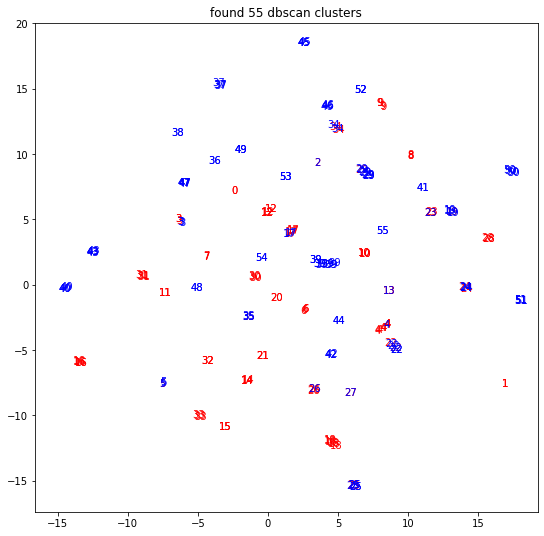

2
3
3
2


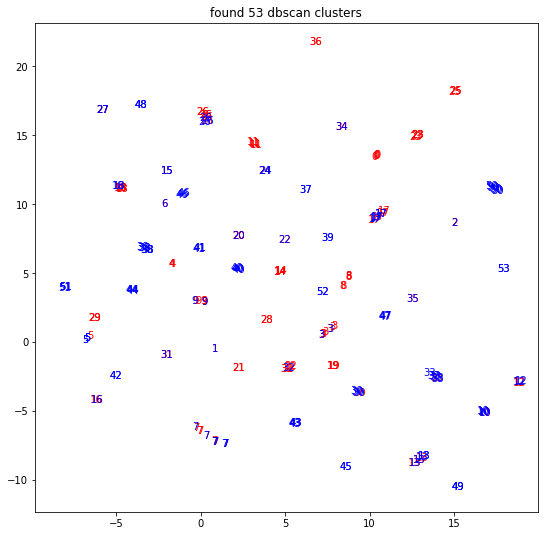

4
12
2
4


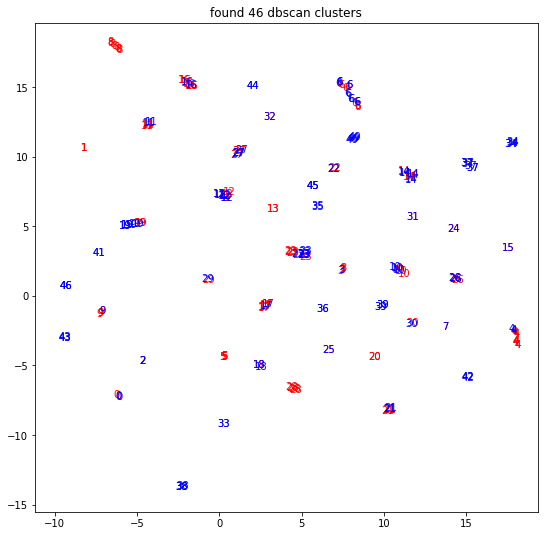

In [158]:
random_colors = np.random.rand(4, 3)

for method in ['raw', 'transformed', 'vae_mu']:
    labels = q.dbscan_labels[method]
    u = q.fractions_u[method]
    plt.figure(figsize=(9, 9))
    colors = np.tile([0., 0., 0.], (len(labels), 1))
    two_colors = np.array([[1., 0., 0.], [0., 0., 1.]])
    hot_indices = [39, 4, 29, 22]
    for color, index in zip(random_colors, hot_indices):
        matches = np.where(labels == index)
        print(len(matches[0]))
        colors[matches, :] = color
    plt.scatter(u[:, 0], u[:, 1], c=cohort_info, alpha=0)
    ax = plt.gca()
    texts = list(map(str, labels))    
    cohort_colors = two_colors[cohort_info, :]
    for i in range(len(u)):
        ax.annotate(texts[i], (u[i, 0], u[i, 1]), color=cohort_colors[i, :])
    # plt.text(u[:, 0], u[:, 1], texts, color=colors)
    plt.title(f'found {max(labels)} dbscan clusters')
    plt.show()

12
10
9
7


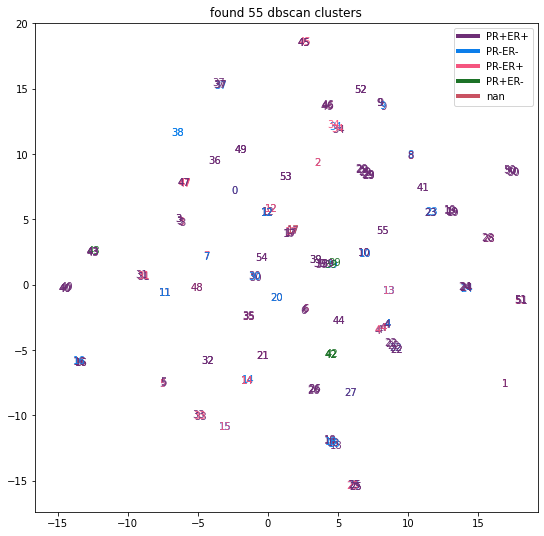

2
3
3
2


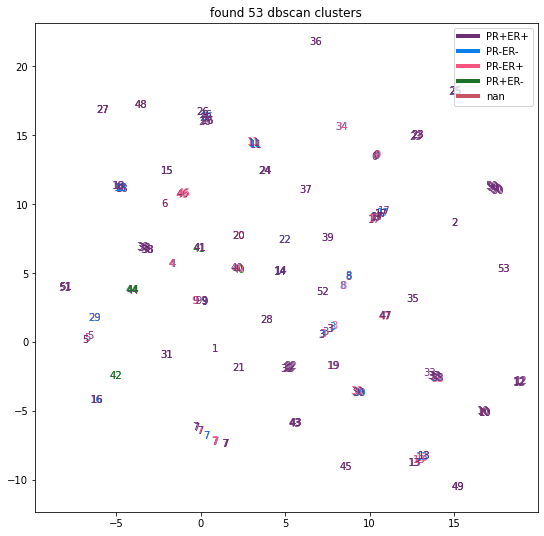

4
12
2
4


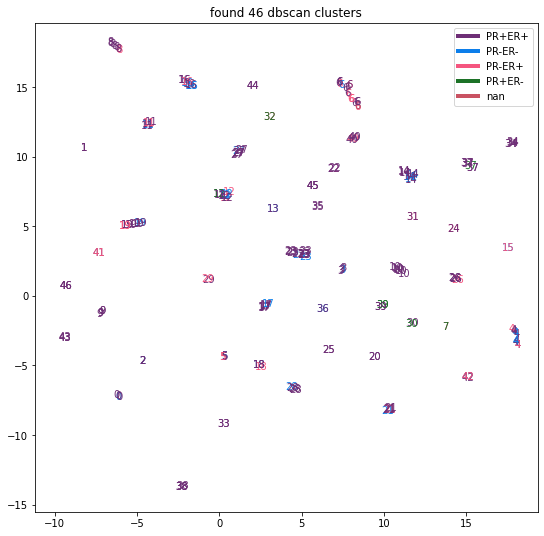

In [175]:
random_colors = np.random.rand(5, 3)

for method in ['raw', 'transformed', 'vae_mu']:
    labels = q.dbscan_labels[method]
    u = q.fractions_u[method]
    plt.figure(figsize=(9, 9))
    colors = np.tile([0., 0., 0.], (len(labels), 1))
    hot_indices = [39, 4, 29, 22]
    for color, index in zip(random_colors, hot_indices):
        matches = np.where(labels == index)
        print(len(matches[0]))
        colors[matches, :] = color
    plt.scatter(u[:, 0], u[:, 1], alpha=0)
    ax = plt.gca()
    texts = list(map(str, labels))    
    cohort_colors = random_colors[tumor_info, :]
    for i in range(len(u)):
        ax.annotate(texts[i], (u[i, 0], u[i, 1]), color=cohort_colors[i, :])
    # plt.text(u[:, 0], u[:, 1], texts, color=colors)
    plt.title(f'found {max(labels)} dbscan clusters')
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=random_colors[i], lw=4) for i in range(5)]
    ax.legend(custom_lines, ['PR+ER+', 'PR-ER-', 'PR-ER+', 'PR+ER-', 'nan'])
    plt.show()